In [53]:
#Import all the necessary libraries

import pandas as pd 
import numpy as np 
import os                
from datetime import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import time
import matplotlib.pyplot as plt
from math import sin, cos, tan
from scipy import stats
import matplotlib.dates as mdates
import seaborn as sns
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from tqdm.notebook import tqdm
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import time

In [4]:
#Load in all of the data files and combine them into a single DataFrame
# Directory where your files are located
directory = './Data/'
dfs = []

#loop through all the files in a data directory
for filename in os.listdir(directory):
    #ignore a file start with the name weekly, thats the mortageg rates data 
    if not filename.startswith("weekly"):
        #read file path 
        filepath = os.path.join(directory, filename)
        #read a file in a dataframe
        df = pd.read_csv(filepath, encoding='ISO-8859-1')
        #append the file in dictionary 
        dfs.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)    
combined_df.head(10)

,MLS #,Class,Property Type,Address,City,Zip,Neighborhood,Subdivision,Bedrooms,Total Baths,Total Living Area SqFt,Acres,Year Built,List Date,Closing Date,Days On Market,List Price,Sold Price
0,LP649830,RESIDENTIAL,Single Family Residence,2263 Shaw Rd Extension,Fayetteville,28311,NaN,NaN,3.0,1,0,NaN,1977.0,2/9/2021,3/11/2021,9,"$79,900",$79
1,2354950,RESIDENTIAL,Single Family Residence,97 Allie Clay Road,Roxboro,27573,NaN,Not in a Subdivision,3.0,1,"1,118",.51-.75 Acres,1934.0,11/22/2020,1/12/2021,13,"$40,000","$15,000"
2,LP630668,RESIDENTIAL,Manufactured,146 Ralph Hunt Boulevard,Orrum,28369,NaN,NaN,3.0,2,0,NaN,1995.0,4/21/2020,2/1/2021,254,"$36,000","$17,000"
3,LP630661,RESIDENTIAL,Manufactured,163 Ralph Hunt Boulevard,Orrum,28369,NaN,NaN,3.0,2,0,NaN,1998.0,4/21/2020,2/1/2021,254,"$29,000","$17,000"
4,LP624150,RESIDENTIAL,Single Family Residence,405 Mcleod Road,Red Springs,28377,NaN,NaN,2.0,1,0,NaN,1940.0,1/7/2020,1/25/2021,357,"$22,000","$18,500"
5,2365371,RESIDENTIAL,Manufactured,921 West Street,Smithfield,27577,NaN,Not in a Subdivision,3.0,1,650,0-.25 Acres,1972.0,2/5/2021,3/26/2021,1,"$20,000","$20,000"
6,LP630389,RESIDENTIAL,Manufactured,555 Ralph Hunt Boulevard,Orrum,28369,NaN,NaN,3.0,2,0,NaN,1998.0,4/14/2020,2/1/2021,261,"$38,500","$20,000"
7,LP630671,RESIDENTIAL,Manufactured,82 Ralph Hunt Boulevard,Orrum,28369,NaN,NaN,3.0,2,0,NaN,1997.0,4/21/2020,2/1/2021,254,"$39,000","$20,000"
8,LP648914,RESIDENTIAL,Single Family Residence,216 Register Street,Sanford,27330,NaN,Hillcrest,0.0,0,0,NaN,1930.0,1/21/2021,2/10/2021,12,"$34,000","$20,000"
9,116488,RESIDENTIAL,Single Family Residence,413 NE Market Street,Reidsville,27320,NaN,NaN,2.0,2,0,.51-.75 Acres,1900.0,2/11/2021,3/26/2021,25,"$31,500","$22,000"


In [5]:
#Checking how many values are null per column
combined_df.isnull().sum()

MLS #                          0
Class                          0
Property Type                  0
Address                        0
City                           0
Zip                           42
Neighborhood              162151
Subdivision                17877
Bedrooms                      18
Total Baths                    0
Total Living Area SqFt         0
Acres                      10856
Year Built                    17
List Date                      0
Closing Date                   0
Days On Market                 0
List Price                     0
Sold Price                     0
dtype: int64

In [6]:
#Checking how many values are null per column
combined_df.describe

<bound method NDFrame.describe of            MLS #        Class            Property Type  \
0       LP649830  RESIDENTIAL  Single Family Residence   
1        2354950  RESIDENTIAL  Single Family Residence   
2       LP630668  RESIDENTIAL             Manufactured   
3       LP630661  RESIDENTIAL             Manufactured   
4       LP624150  RESIDENTIAL  Single Family Residence   
...          ...          ...                      ...   
168792   2473018  RESIDENTIAL  Single Family Residence   
168793  10003230  RESIDENTIAL  Single Family Residence   
168794   2490937  RESIDENTIAL  Single Family Residence   
168795  10029216  RESIDENTIAL  Single Family Residence   
168796  10009864  RESIDENTIAL  Single Family Residence   

                         Address          City    Zip Neighborhood  \
0         2263 Shaw Rd Extension  Fayetteville  28311          NaN   
1             97 Allie Clay Road       Roxboro  27573          NaN   
2       146 Ralph Hunt Boulevard         Orrum  28369      

In [7]:
#Checking df Info
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168797 entries, 0 to 168796
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   MLS #                   168797 non-null  object 
 1   Class                   168797 non-null  object 
 2   Property Type           168797 non-null  object 
 3   Address                 168797 non-null  object 
 4   City                    168797 non-null  object 
 5   Zip                     168755 non-null  object 
 6   Neighborhood            6646 non-null    object 
 7   Subdivision             150920 non-null  object 
 8   Bedrooms                168779 non-null  float64
 9   Total Baths             168797 non-null  int64  
 10  Total Living Area SqFt  168797 non-null  object 
 11  Acres                   157941 non-null  object 
 12  Year Built              168780 non-null  float64
 13  List Date               168797 non-null  object 
 14  Closing Date        

In [8]:
combined_df.columns

Index(['MLS #', 'Class', 'Property Type', 'Address', 'City', 'Zip',
       'Neighborhood', 'Subdivision', 'Bedrooms', 'Total Baths',
       'Total Living Area SqFt', 'Acres', 'Year Built', 'List Date',
       'Closing Date', 'Days On Market', 'List Price', 'Sold Price'],
      dtype='object')

In [9]:
# Drop the 'Neighborhood' column
combined_df = combined_df.drop('Neighborhood', axis=1)

# Drop the 'Subdivision' column
combined_df = combined_df.drop('Subdivision', axis=1)

combined_df.isnull().sum()

MLS #                         0
Class                         0
Property Type                 0
Address                       0
City                          0
Zip                          42
Bedrooms                     18
Total Baths                   0
Total Living Area SqFt        0
Acres                     10856
Year Built                   17
List Date                     0
Closing Date                  0
Days On Market                0
List Price                    0
Sold Price                    0
dtype: int64

In [10]:
#Drop the rows with missing values
combined_df.dropna(inplace=True)

combined_df

,MLS #,Class,Property Type,Address,City,Zip,Bedrooms,Total Baths,Total Living Area SqFt,Acres,Year Built,List Date,Closing Date,Days On Market,List Price,Sold Price
1,2354950,RESIDENTIAL,Single Family Residence,97 Allie Clay Road,Roxboro,27573,3.0,1,"1,118",.51-.75 Acres,1934.0,11/22/2020,1/12/2021,13,"$40,000","$15,000"
5,2365371,RESIDENTIAL,Manufactured,921 West Street,Smithfield,27577,3.0,1,650,0-.25 Acres,1972.0,2/5/2021,3/26/2021,1,"$20,000","$20,000"
9,116488,RESIDENTIAL,Single Family Residence,413 NE Market Street,Reidsville,27320,2.0,2,0,.51-.75 Acres,1900.0,2/11/2021,3/26/2021,25,"$31,500","$22,000"
11,2355534,RESIDENTIAL,Single Family Residence,710 Water Street,Henderson,27536,2.0,1,"1,012",0-.25 Acres,1984.0,11/29/2020,1/15/2021,17,"$40,000","$24,000"
12,2360306,RESIDENTIAL,Single Family Residence,1918 Powell Street,Fayetteville,28306,2.0,1,859,0-.25 Acres,1940.0,1/6/2021,1/22/2021,5,"$25,000","$24,000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168792,2473018,RESIDENTIAL,Single Family Residence,250 Blue Violet Way,Durham,27713,5.0,9,"10,850",6-10.9 Acres,2008.0,9/8/2022,5/1/2024,587,"$4,995,000","$4,415,000"
168793,10003230,RESIDENTIAL,Single Family Residence,1711 Hunting Ridge Road,Raleigh,27615,4.0,6,"5,951",.51-.75 Acres,2023.0,12/22/2023,4/11/2024,0,"$5,500,000","$5,000,000"
168794,2490937,RESIDENTIAL,Single Family Residence,4821 Parker Meadow Drive,Raleigh,27614,6.0,10,"8,074",1-2.9 Acres,2023.0,1/18/2023,5/3/2024,0,"$5,121,787","$5,121,787"
168795,10029216,RESIDENTIAL,Single Family Residence,702 Old School Road,Chapel Hill,27516,5.0,8,"6,852",11+ Acres,2016.0,5/14/2024,5/14/2024,0,"$5,750,000","$5,750,000"


In [11]:
# Replace float Acres values with simplified float values in the 'Acres' column
combined_df['Acres'] = combined_df['Acres'].replace('0-.25 Acres', 0.0)
combined_df['Acres'] = combined_df['Acres'].replace('.26-.5 Acres', 0.26)
combined_df['Acres'] = combined_df['Acres'].replace('.51-.75 Acres', 0.51)
combined_df['Acres'] = combined_df['Acres'].replace('.76-.99 Acres', 0.76)
combined_df['Acres'] = combined_df['Acres'].replace('1-2.9 Acres', 1.0)
combined_df['Acres'] = combined_df['Acres'].replace('3-5.9 Acres', 3.0)
combined_df['Acres'] = combined_df['Acres'].replace('6-10.9 Acres', 6.0)
combined_df['Acres'] = combined_df['Acres'].replace('11+ Acres', 11.0)

#Convert the Acres column to an integer
combined_df['Acres'] = combined_df['Acres'].astype(int)

combined_df['Acres'].unique()


array([ 0,  1,  3,  6, 11])

In [12]:
#Convert the Year Build column to an integer
combined_df['Year Built'] = combined_df['Year Built'].astype(int)

In [13]:
#Covert Zip to a string so we can slice it
combined_df['Zip'] = combined_df['Zip'].astype(str)

# Slice the 'Zip' column to just the first 5 characters
combined_df['Zip'] = combined_df['Zip'].str.slice(0, 5)

#Convert the Zip column to an integer
combined_df['Zip'] = combined_df['Zip'].astype(int)


In [14]:
# Convert the 'List Date' and 'Closing Date' columns to datetime
combined_df['List Date'] = pd.to_datetime(combined_df['List Date'])
combined_df['Closing Date'] = pd.to_datetime(combined_df['Closing Date'])

# Calculate the number of days between 'List Date' and 'Closing Date'
combined_df['Days Between'] = (combined_df['Closing Date'] - combined_df['List Date']).dt.days

combined_df

,MLS #,Class,Property Type,Address,City,Zip,Bedrooms,Total Baths,Total Living Area SqFt,Acres,Year Built,List Date,Closing Date,Days On Market,List Price,Sold Price,Days Between
1,2354950,RESIDENTIAL,Single Family Residence,97 Allie Clay Road,Roxboro,27573,3.0,1,"1,118",0,1934,2020-11-22,2021-01-12,13,"$40,000","$15,000",51
5,2365371,RESIDENTIAL,Manufactured,921 West Street,Smithfield,27577,3.0,1,650,0,1972,2021-02-05,2021-03-26,1,"$20,000","$20,000",49
9,116488,RESIDENTIAL,Single Family Residence,413 NE Market Street,Reidsville,27320,2.0,2,0,0,1900,2021-02-11,2021-03-26,25,"$31,500","$22,000",43
11,2355534,RESIDENTIAL,Single Family Residence,710 Water Street,Henderson,27536,2.0,1,"1,012",0,1984,2020-11-29,2021-01-15,17,"$40,000","$24,000",47
12,2360306,RESIDENTIAL,Single Family Residence,1918 Powell Street,Fayetteville,28306,2.0,1,859,0,1940,2021-01-06,2021-01-22,5,"$25,000","$24,000",16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168792,2473018,RESIDENTIAL,Single Family Residence,250 Blue Violet Way,Durham,27713,5.0,9,"10,850",6,2008,2022-09-08,2024-05-01,587,"$4,995,000","$4,415,000",601
168793,10003230,RESIDENTIAL,Single Family Residence,1711 Hunting Ridge Road,Raleigh,27615,4.0,6,"5,951",0,2023,2023-12-22,2024-04-11,0,"$5,500,000","$5,000,000",111
168794,2490937,RESIDENTIAL,Single Family Residence,4821 Parker Meadow Drive,Raleigh,27614,6.0,10,"8,074",1,2023,2023-01-18,2024-05-03,0,"$5,121,787","$5,121,787",471
168795,10029216,RESIDENTIAL,Single Family Residence,702 Old School Road,Chapel Hill,27516,5.0,8,"6,852",11,2016,2024-05-14,2024-05-14,0,"$5,750,000","$5,750,000",0


In [15]:
# Count the number of 0 values in the 'Total Living Area SqFt' column
num_zeros = combined_df['Total Living Area SqFt'].value_counts().get(0, 0)
print(num_zeros)

16387


C:\Users\David\AppData\Local\Temp\ipykernel_11432\4168313785.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  num_zeros = combined_df['Total Living Area SqFt'].value_counts().get(0, 0)


In [16]:
#Convert the Bedrooms column to an integer
combined_df['Bedrooms'] = combined_df['Bedrooms'].astype(int)
combined_df['Bedrooms'].unique()

array([ 3,  2,  4,  1,  5, 10,  6,  8,  7,  0, 11, 13, 14, 43,  9, 44])

In [17]:
#Convert the Total Baths column to an integer
combined_df['Total Baths'] = combined_df['Total Baths'].astype(int)
combined_df['Total Baths'].unique()

array([ 1,  2,  3,  4,  5,  7,  6,  0,  8,  9, 10, 12, 17, 32, 14, 23, 26,
       11, 34, 22])

In [18]:
#Define the number of zeros in the 'Total Baths' column
num_zeros = combined_df['Total Baths'].value_counts().get(0, 0)
print(num_zeros)

50


In [19]:
# Drop all the rows that have a 0 in the 'Total Baths' column
combined_df = combined_df[combined_df['Total Baths'] != 0]

#Recheck the number of zeros in the 'Total Baths' column
num_zeros = combined_df['Total Baths'].value_counts().get(0, 0)
print(num_zeros)

0


In [20]:
#Covert Sqft to a string so we can remove the commas
combined_df['Total Living Area SqFt'] = combined_df['Total Living Area SqFt'].astype(str)

# Remove commas from the 'Total Living Area SqFt' column
combined_df['Total Living Area SqFt'] = combined_df['Total Living Area SqFt'].str.replace(',', '')

# Convert the 'Total Living Area SqFt' column to an integer
combined_df['Total Living Area SqFt'] = combined_df['Total Living Area SqFt'].astype(int)

# Drop all the rows that have a 0 in the 'Total Baths' column
combined_df = combined_df[combined_df['Total Living Area SqFt'] != 0]

num_zeros = combined_df['Total Living Area SqFt'].value_counts().get(0, 0)
print(num_zeros)


C:\Users\David\AppData\Local\Temp\ipykernel_11432\4065630321.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['Total Living Area SqFt'] = combined_df['Total Living Area SqFt'].astype(str)
C:\Users\David\AppData\Local\Temp\ipykernel_11432\4065630321.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['Total Living Area SqFt'] = combined_df['Total Living Area SqFt'].str.replace(',', '')
C:\Users\David\AppData\Local\Temp\ipykernel_11432\4065630321.py:8: SettingWithCopyWarning: 
A val

0


In [21]:
#Covert List Price and Sold Price to a string so we can remove the dollar sign and commas
combined_df['List Price'] = combined_df['List Price'].astype(str)
combined_df['Sold Price'] = combined_df['Sold Price'].astype(str)

# Remove dollar signs and commas from the 'List Price' and 'Sold Price' column
combined_df['List Price'] = combined_df['List Price'].replace('[$,]', '', regex=True)
combined_df['Sold Price'] = combined_df['Sold Price'].replace('[$,]', '', regex=True)

# Convert the 'List Price' and 'Sold Price' columns to integers
combined_df['List Price'] = combined_df['List Price'].astype(int)
combined_df['Sold Price'] = combined_df['Sold Price'].astype(int)

# Calculate the profit made on each house
combined_df['Profit'] = combined_df['Sold Price'] - combined_df['List Price']

combined_df.head(10)




,MLS #,Class,Property Type,Address,City,Zip,Bedrooms,Total Baths,Total Living Area SqFt,Acres,Year Built,List Date,Closing Date,Days On Market,List Price,Sold Price,Days Between,Profit
1,2354950,RESIDENTIAL,Single Family Residence,97 Allie Clay Road,Roxboro,27573,3,1,1118,0,1934,2020-11-22,2021-01-12,13,40000,15000,51,-25000
5,2365371,RESIDENTIAL,Manufactured,921 West Street,Smithfield,27577,3,1,650,0,1972,2021-02-05,2021-03-26,1,20000,20000,49,0
11,2355534,RESIDENTIAL,Single Family Residence,710 Water Street,Henderson,27536,2,1,1012,0,1984,2020-11-29,2021-01-15,17,40000,24000,47,-16000
12,2360306,RESIDENTIAL,Single Family Residence,1918 Powell Street,Fayetteville,28306,2,1,859,0,1940,2021-01-06,2021-01-22,5,25000,24000,16,-1000
14,2301316,RESIDENTIAL,Single Family Residence,505 Ivey Street,Henderson,27536,3,2,1100,0,1958,2020-02-11,2021-02-05,309,39000,25000,360,-14000
15,2300217,RESIDENTIAL,Single Family Residence,877 Lamb Street,Henderson,27536,3,1,1086,0,1950,2020-02-05,2021-02-05,315,35000,25000,366,-10000
16,2357601,RESIDENTIAL,Single Family Residence,310 Hall Avenue,Burlington,27217,3,1,1414,0,1919,2020-12-12,2021-02-25,8,29900,25000,75,-4900
17,2369657,RESIDENTIAL,Single Family Residence,504 SE New Bern Street,Wilson,27893,3,1,1395,0,1945,2021-03-02,2021-03-16,2,29900,25000,14,-4900
18,2355248,RESIDENTIAL,Single Family Residence,722 Eaton Street,Henderson,27536,4,3,1675,0,1955,2020-11-24,2021-01-06,30,38000,26000,43,-12000
19,2365135,RESIDENTIAL,Single Family Residence,324 Arch Street,Henderson,27536,3,1,1192,0,1952,2021-02-04,2021-02-25,12,29900,26000,21,-3900


In [22]:
#Drop the MLS Number, Days On Market, and Class column
#combined_df = combined_df.drop('MLS #', axis=1) - This column is needed for the final output as a UID

#Drop Unnecessary Columns
combined_df = combined_df.drop('Days On Market', axis=1)
combined_df = combined_df.drop('Class', axis=1)

In [23]:
combined_df.head(10)

,MLS #,Property Type,Address,City,Zip,Bedrooms,Total Baths,Total Living Area SqFt,Acres,Year Built,List Date,Closing Date,List Price,Sold Price,Days Between,Profit
1,2354950,Single Family Residence,97 Allie Clay Road,Roxboro,27573,3,1,1118,0,1934,2020-11-22,2021-01-12,40000,15000,51,-25000
5,2365371,Manufactured,921 West Street,Smithfield,27577,3,1,650,0,1972,2021-02-05,2021-03-26,20000,20000,49,0
11,2355534,Single Family Residence,710 Water Street,Henderson,27536,2,1,1012,0,1984,2020-11-29,2021-01-15,40000,24000,47,-16000
12,2360306,Single Family Residence,1918 Powell Street,Fayetteville,28306,2,1,859,0,1940,2021-01-06,2021-01-22,25000,24000,16,-1000
14,2301316,Single Family Residence,505 Ivey Street,Henderson,27536,3,2,1100,0,1958,2020-02-11,2021-02-05,39000,25000,360,-14000
15,2300217,Single Family Residence,877 Lamb Street,Henderson,27536,3,1,1086,0,1950,2020-02-05,2021-02-05,35000,25000,366,-10000
16,2357601,Single Family Residence,310 Hall Avenue,Burlington,27217,3,1,1414,0,1919,2020-12-12,2021-02-25,29900,25000,75,-4900
17,2369657,Single Family Residence,504 SE New Bern Street,Wilson,27893,3,1,1395,0,1945,2021-03-02,2021-03-16,29900,25000,14,-4900
18,2355248,Single Family Residence,722 Eaton Street,Henderson,27536,4,3,1675,0,1955,2020-11-24,2021-01-06,38000,26000,43,-12000
19,2365135,Single Family Residence,324 Arch Street,Henderson,27536,3,1,1192,0,1952,2021-02-04,2021-02-25,29900,26000,21,-3900


In [24]:

combined_df['Property Type'].unique()

array(['Single Family Residence', 'Manufactured', 'Condo', 'Townhouse',
       'Duplex', 'Other', 'Farm', 'Cabin', 'Ranch', 'Triplex',
       'Quadruplex'], dtype=object)

In [25]:
#Change the 'Total Living Area SqFt' column name to 'SqFt'
combined_df = combined_df.rename(columns={"Total Living Area SqFt": "SqFt"})

#Change the 'Profit' column name to 'Over Asking'  
combined_df = combined_df.rename(columns={"Profit": "Over Asking"})

#Change the 'Days Between' column name to 'Days on Market'
combined_df = combined_df.rename(columns={"Days Between": "Days on Market"})


combined_df.head()

,MLS #,Property Type,Address,City,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,Closing Date,List Price,Sold Price,Days on Market,Over Asking
1,2354950,Single Family Residence,97 Allie Clay Road,Roxboro,27573,3,1,1118,0,1934,2020-11-22,2021-01-12,40000,15000,51,-25000
5,2365371,Manufactured,921 West Street,Smithfield,27577,3,1,650,0,1972,2021-02-05,2021-03-26,20000,20000,49,0
11,2355534,Single Family Residence,710 Water Street,Henderson,27536,2,1,1012,0,1984,2020-11-29,2021-01-15,40000,24000,47,-16000
12,2360306,Single Family Residence,1918 Powell Street,Fayetteville,28306,2,1,859,0,1940,2021-01-06,2021-01-22,25000,24000,16,-1000
14,2301316,Single Family Residence,505 Ivey Street,Henderson,27536,3,2,1100,0,1958,2020-02-11,2021-02-05,39000,25000,360,-14000


In [26]:
combined_df.isnull().sum()

MLS #             0
Property Type     0
Address           0
City              0
Zip               0
Bedrooms          0
Total Baths       0
SqFt              0
Acres             0
Year Built        0
List Date         0
Closing Date      0
List Price        0
Sold Price        0
Days on Market    0
Over Asking       0
dtype: int64

In [27]:
#Drop the rows with missing values
combined_df.dropna(inplace=True)

combined_df.isnull().sum()

MLS #             0
Property Type     0
Address           0
City              0
Zip               0
Bedrooms          0
Total Baths       0
SqFt              0
Acres             0
Year Built        0
List Date         0
Closing Date      0
List Price        0
Sold Price        0
Days on Market    0
Over Asking       0
dtype: int64

In [28]:
# Copy the data frame to a new data frame
sfr_df = combined_df.copy()

# Keep only the 'Single Family Residence' values in column 'Property Type'
sfr_df = sfr_df[sfr_df['Property Type'] == 'Single Family Residence']

# Drop the 'Property Type' column
sfr_df = sfr_df.drop(columns=['Property Type'])


sfr_df.head()

,MLS #,Address,City,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,Closing Date,List Price,Sold Price,Days on Market,Over Asking
1,2354950,97 Allie Clay Road,Roxboro,27573,3,1,1118,0,1934,2020-11-22,2021-01-12,40000,15000,51,-25000
11,2355534,710 Water Street,Henderson,27536,2,1,1012,0,1984,2020-11-29,2021-01-15,40000,24000,47,-16000
12,2360306,1918 Powell Street,Fayetteville,28306,2,1,859,0,1940,2021-01-06,2021-01-22,25000,24000,16,-1000
14,2301316,505 Ivey Street,Henderson,27536,3,2,1100,0,1958,2020-02-11,2021-02-05,39000,25000,360,-14000
15,2300217,877 Lamb Street,Henderson,27536,3,1,1086,0,1950,2020-02-05,2021-02-05,35000,25000,366,-10000


In [29]:
# Remove cities with counts less than 10
sfr_df = sfr_df[sfr_df['City'].map(sfr_df['City'].value_counts()) > 1000]
sfr_df['City'].value_counts()

City
Raleigh           17643
Durham            11299
Clayton            6264
Fuquay Varina      5285
Cary               5191
Wake Forest        5150
Apex               4499
Chapel Hill        3802
Holly Springs      3141
Garner             3074
Zebulon            2277
Wendell            2204
Burlington         2118
Youngsville        2027
Sanford            1864
Angier             1689
Knightdale         1687
Smithfield         1557
Mebane             1528
Franklinton        1518
Pittsboro          1453
Benson             1301
Willow Springs     1188
Rocky Mount        1150
Louisburg          1142
Graham             1142
Hillsborough       1101
Selma              1019
Name: count, dtype: int64

In [30]:
# Remove unreliable data
sfr_df = sfr_df[sfr_df['Bedrooms'] <= 12]
sfr_df = sfr_df[sfr_df['Bedrooms'] >= 1]
sfr_df = sfr_df[sfr_df['Total Baths'] <= 12]
sfr_df = sfr_df[sfr_df['Total Baths'] >= 1]
sfr_df = sfr_df[sfr_df['SqFt'] >= 100]
sfr_df = sfr_df[sfr_df['Year Built'] >= 1700]
sfr_df = sfr_df[sfr_df['Year Built'] <= 2024]
sfr_df = sfr_df[sfr_df['Sold Price'] >= 50000]

In [31]:
sfr_df.describe()

,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,Closing Date,List Price,Sold Price,Days on Market,Over Asking
count,93203.000000,93203.000000,93203.000000,93203.000000,93203.000000,93203.000000,93203,93203,9.320300e+04,9.320300e+04,93203.000000,9.320300e+04
mean,27552.657854,3.568673,2.985419,2391.678100,0.214328,2000.745255,2022-05-05 00:15:41.840928,2022-08-02 11:50:08.104889600,4.935237e+05,5.007775e+05,89.482248,7.253746e+03
min,17502.000000,1.000000,1.000000,110.000000,0.000000,1721.000000,2017-04-27 00:00:00,2021-01-04 00:00:00,3.180000e+04,5.000000e+04,0.000000,-3.454000e+06
25%,27519.000000,3.000000,2.000000,1660.000000,0.000000,1991.000000,2021-07-01 00:00:00,2021-09-20 00:00:00,3.250000e+05,3.300000e+05,37.000000,-4.000000e+03
50%,27549.000000,3.000000,3.000000,2253.000000,0.000000,2006.000000,2022-04-14 00:00:00,2022-06-27 00:00:00,4.199990e+05,4.250000e+05,55.000000,0.000000e+00
75%,27609.000000,4.000000,3.000000,2896.000000,0.000000,2021.000000,2023-03-11 00:00:00,2023-06-01 00:00:00,5.750000e+05,5.834750e+05,108.000000,1.510000e+04
max,77332.000000,10.000000,12.000000,20283.000000,11.000000,2024.000000,2024-06-17 00:00:00,2024-06-18 00:00:00,7.000000e+06,6.625000e+06,1821.000000,2.930000e+06
std,234.384155,0.815685,1.003049,1011.193534,0.920923,23.864209,NaN,NaN,3.030384e+05,3.008188e+05,88.300021,4.146870e+04


In [32]:
# Extracting year and month from List Date and Closing Date
sfr_df['List Year'] = sfr_df['List Date'].dt.year
sfr_df['List Month'] = sfr_df['List Date'].dt.month
sfr_df['Closing Year'] = sfr_df['Closing Date'].dt.year
sfr_df['Closing Month'] = sfr_df['Closing Date'].dt.month

sfr_df.head()

,MLS #,Address,City,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,Closing Date,List Price,Sold Price,Days on Market,Over Asking,List Year,List Month,Closing Year,Closing Month
91,2346306,6209 Old Fairground Road,Benson,27504,3,1,1075,0,1968,2020-10-02,2021-03-31,65000,52263,180,-12737,2020,10,2021,3
94,2365360,917 West Street,Smithfield,27577,3,1,975,0,1950,2021-02-05,2021-03-26,50000,54000,49,4000,2021,2,2021,3
107,2356592,1208 Paul Street,Rocky Mount,27803,3,2,1348,0,1962,2020-12-04,2021-03-02,59900,57500,88,-2400,2020,12,2021,3
120,2366022,1329 N Mebane Street,Burlington,27217,2,1,930,0,1940,2021-02-10,2021-03-03,65000,60000,21,-5000,2021,2,2021,3
125,2372790,520 Barnes Street,Sanford,27330,3,1,1044,0,1948,2021-03-18,2021-03-31,62000,62000,13,0,2021,3,2021,3


In [33]:
# Feature Engineering
sfr_df['Price Increase Percentage'] = (sfr_df['Sold Price'] - sfr_df['List Price']) / sfr_df['List Price']
sfr_df['Age of Property'] = sfr_df['Closing Year'] - sfr_df['Year Built']

sfr_df.head()

,MLS #,Address,City,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,...,List Price,Sold Price,Days on Market,Over Asking,List Year,List Month,Closing Year,Closing Month,Price Increase Percentage,Age of Property
91,2346306,6209 Old Fairground Road,Benson,27504,3,1,1075,0,1968,2020-10-02,...,65000,52263,180,-12737,2020,10,2021,3,-0.195954,53
94,2365360,917 West Street,Smithfield,27577,3,1,975,0,1950,2021-02-05,...,50000,54000,49,4000,2021,2,2021,3,0.080000,71
107,2356592,1208 Paul Street,Rocky Mount,27803,3,2,1348,0,1962,2020-12-04,...,59900,57500,88,-2400,2020,12,2021,3,-0.040067,59
120,2366022,1329 N Mebane Street,Burlington,27217,2,1,930,0,1940,2021-02-10,...,65000,60000,21,-5000,2021,2,2021,3,-0.076923,81
125,2372790,520 Barnes Street,Sanford,27330,3,1,1044,0,1948,2021-03-18,...,62000,62000,13,0,2021,3,2021,3,0.000000,73


In [34]:
# Subtracting 2020 from the year to both to effectively scale the year and to turn it into an ordinal category
sfr_df['Closing Year'] = sfr_df['Closing Year'] - 2020
sfr_df['List Year'] = sfr_df['List Year'] - 2020

sfr_df.head()

,MLS #,Address,City,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,...,List Price,Sold Price,Days on Market,Over Asking,List Year,List Month,Closing Year,Closing Month,Price Increase Percentage,Age of Property
91,2346306,6209 Old Fairground Road,Benson,27504,3,1,1075,0,1968,2020-10-02,...,65000,52263,180,-12737,0,10,1,3,-0.195954,53
94,2365360,917 West Street,Smithfield,27577,3,1,975,0,1950,2021-02-05,...,50000,54000,49,4000,1,2,1,3,0.080000,71
107,2356592,1208 Paul Street,Rocky Mount,27803,3,2,1348,0,1962,2020-12-04,...,59900,57500,88,-2400,0,12,1,3,-0.040067,59
120,2366022,1329 N Mebane Street,Burlington,27217,2,1,930,0,1940,2021-02-10,...,65000,60000,21,-5000,1,2,1,3,-0.076923,81
125,2372790,520 Barnes Street,Sanford,27330,3,1,1044,0,1948,2021-03-18,...,62000,62000,13,0,1,3,1,3,0.000000,73


In [35]:
mortgage_rates = pd.read_excel('./Data/weekly_mortgage_data.xlsx', usecols=[0, 1])
mortgage_rates.head()


,Week,30-YR FRM
0,1971-04-02,7.33
1,1971-04-09,7.31
2,1971-04-16,7.31
3,1971-04-23,7.31
4,1971-04-30,7.29


In [36]:
# Convert the "Week" column in mortgage_rates to datetime
mortgage_rates['Week'] = pd.to_datetime(mortgage_rates['Week'])

# Merge the mortgage_rates DataFrame with the sfr_df DataFrame based on the closest date
sfr_df['Rate'] = sfr_df['Closing Date'].apply(lambda x: mortgage_rates.loc[mortgage_rates['Week'].sub(x).abs().idxmin(), '30-YR FRM'])

sfr_df.head()

,MLS #,Address,City,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,...,Sold Price,Days on Market,Over Asking,List Year,List Month,Closing Year,Closing Month,Price Increase Percentage,Age of Property,Rate
91,2346306,6209 Old Fairground Road,Benson,27504,3,1,1075,0,1968,2020-10-02,...,52263,180,-12737,0,10,1,3,-0.195954,53,3.18
94,2365360,917 West Street,Smithfield,27577,3,1,975,0,1950,2021-02-05,...,54000,49,4000,1,2,1,3,0.080000,71,3.17
107,2356592,1208 Paul Street,Rocky Mount,27803,3,2,1348,0,1962,2020-12-04,...,57500,88,-2400,0,12,1,3,-0.040067,59,3.02
120,2366022,1329 N Mebane Street,Burlington,27217,2,1,930,0,1940,2021-02-10,...,60000,21,-5000,1,2,1,3,-0.076923,81,3.02
125,2372790,520 Barnes Street,Sanford,27330,3,1,1044,0,1948,2021-03-18,...,62000,13,0,1,3,1,3,0.000000,73,3.18


In [37]:
# Handling outliers
for col in ['List Price', 'Sold Price', 'SqFt', 'Days on Market', "Bedrooms", "Total Baths", "Age of Property"]:
    sfr_df = sfr_df[np.abs(stats.zscore(sfr_df[col])) < 3]

sfr_df

,MLS #,Address,City,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,...,Sold Price,Days on Market,Over Asking,List Year,List Month,Closing Year,Closing Month,Price Increase Percentage,Age of Property,Rate
91,2346306,6209 Old Fairground Road,Benson,27504,3,1,1075,0,1968,2020-10-02,...,52263,180,-12737,0,10,1,3,-0.195954,53,3.18
94,2365360,917 West Street,Smithfield,27577,3,1,975,0,1950,2021-02-05,...,54000,49,4000,1,2,1,3,0.080000,71,3.17
107,2356592,1208 Paul Street,Rocky Mount,27803,3,2,1348,0,1962,2020-12-04,...,57500,88,-2400,0,12,1,3,-0.040067,59,3.02
120,2366022,1329 N Mebane Street,Burlington,27217,2,1,930,0,1940,2021-02-10,...,60000,21,-5000,1,2,1,3,-0.076923,81,3.02
125,2372790,520 Barnes Street,Sanford,27330,3,1,1044,0,1948,2021-03-18,...,62000,13,0,1,3,1,3,0.000000,73,3.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168424,10015101,113 Atterbury Street,Chapel Hill,27516,5,5,4605,0,2007,2024-03-04,...,1125000,66,-14750,4,3,4,5,-0.012941,17,7.09
168425,10017496,5008 Upchurch Lane,Wake Forest,27587,4,4,3591,3,2024,2024-03-15,...,1125000,33,125001,4,3,4,4,0.125001,0,7.10
168426,10005625,1708 Midwood Drive,Raleigh,27604,4,3,2719,0,2024,2024-01-11,...,1125000,113,30000,4,1,4,5,0.027397,0,7.22
168427,10007567,236 Inwood Forest Drive,Raleigh,27603,5,4,3407,0,2024,2024-01-22,...,1129619,142,7369,4,1,4,6,0.006566,0,6.95


In [38]:
sfr_df.describe()

,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,Closing Date,List Price,Sold Price,Days on Market,Over Asking,List Year,List Month,Closing Year,Closing Month,Price Increase Percentage,Age of Property,Rate
count,85061.000000,85061.000000,85061.000000,85061.000000,85061.000000,85061.000000,85061,85061,8.506100e+04,8.506100e+04,85061.000000,85061.000000,85061.000000,85061.000000,85061.000000,85061.000000,85061.000000,85061.000000,85061.000000
mean,27552.908513,3.503039,2.862228,2250.734214,0.184667,2001.477257,2022-05-10 23:38:53.370169600,2022-07-30 09:20:24.095649024,4.446640e+05,4.524957e+05,80.403828,7831.739246,1.888327,6.171618,2.100657,6.208156,0.019509,20.623400,5.014895
min,17606.000000,2.000000,1.000000,110.000000,0.000000,1928.000000,2020-02-10 00:00:00,2021-01-04 00:00:00,3.990000e+04,5.000000e+04,0.000000,-494516.000000,0.000000,1.000000,1.000000,1.000000,-0.856632,-1.000000,2.650000
25%,27520.000000,3.000000,2.000000,1630.000000,0.000000,1991.000000,2021-07-08 00:00:00,2021-09-16 00:00:00,3.213180e+05,3.261850e+05,37.000000,-3000.000000,1.000000,3.000000,1.000000,4.000000,-0.007220,1.000000,3.050000
50%,27545.000000,3.000000,3.000000,2190.000000,0.000000,2006.000000,2022-04-18 00:00:00,2022-06-23 00:00:00,4.080000e+05,4.150000e+05,53.000000,0.000000,2.000000,6.000000,2.000000,6.000000,0.000000,16.000000,5.300000
75%,27609.000000,4.000000,3.000000,2771.000000,0.000000,2021.000000,2023-03-16 00:00:00,2023-05-30 00:00:00,5.390000e+05,5.500000e+05,100.000000,15100.000000,3.000000,9.000000,3.000000,9.000000,0.042534,31.000000,6.700000
max,77332.000000,5.000000,5.000000,4863.000000,11.000000,2024.000000,2024-06-17 00:00:00,2024-06-18 00:00:00,1.350000e+06,1.131500e+06,340.000000,600100.000000,4.000000,12.000000,4.000000,12.000000,2.401361,93.000000,7.790000
std,238.057408,0.742519,0.813885,779.328823,0.815809,21.401946,NaN,NaN,1.766341e+05,1.790890e+05,66.695233,27844.126172,1.047262,3.289044,1.009735,3.245935,0.063432,21.370544,1.743965


In [43]:
# Initialize Nominatim API
geolocator = Nominatim(user_agent="nc-housing-price-predictions")

# Function to geocode an address with a delay
def geocode_address(address):
    try:
        location = geolocator.geocode(address, timeout=10)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except GeocoderTimedOut:
        return geocode_address(address)  # Retry if there's a timeout
    except Exception as e:
        print(f"Error geocoding {address}: {e}")
        return None, None

# Create new columns for latitude and longitude
sfr_df['Lat'] = None
sfr_df['Lon'] = None

# Geocode each address with a delay to respect Nominatim's rate limits
for i, row in tqdm(sfr_df.iterrows(), total=sfr_df.shape[0]):
    address = f"{row['Address']}, {row['City']}, NC"
    print (address)
    lat, lon = geocode_address(address)
    sfr_df.at[i, 'Lat'] = lat
    sfr_df.at[i, 'Lon'] = lon
    time.sleep(1)  # Add a 1-second delay between requests

sfr_df = sfr_df.drop('Address', axis=1)

lat_lon_df = sfr_df.copy()

# Save the DataFrame to a CSV file
lat_lon_df.to_csv('Clean_Data/lat_lon_checkpoint.csv', index=False)

lat_lon_df

  0%|          | 0/85061 [00:00<?, ?it/s]

6209 Old Fairground Road, Benson, NC
917 West Street, Smithfield, NC
1208 Paul Street, Rocky Mount, NC
1329 N Mebane Street, Burlington, NC
520 Barnes Street, Sanford, NC
215 N Cobb Avenue, Burlington, NC
301 Williamson Street, Burlington, NC
1801 Belmont Street, Burlington, NC
520 Jones Street, Burlington, NC
5601 E US 70 Highway, Durham, NC
1212 Neal Street, Rocky Mount, NC
601 N Melville Street, Graham, NC
2243 Durham Street Ext, Burlington, NC
760 Chalybeate Springs Road, Angier, NC
506 East End Avenue, Durham, NC
822 Ridgeway Avenue, Durham, NC
121 N West Street, Fuquay Varina, NC
221 Hatch Street, Burlington, NC
4372 S US 301 Highway, Rocky Mount, NC
316 Swift Road, Rocky Mount, NC
2621 Willie Pace Road, Burlington, NC
1173 Hatcher Road, Selma, NC
915 Oakley Street, Graham, NC
1210 Linwood Avenue, Durham, NC
201 Mitchell Lane, Franklinton, NC
1820 Arthur Minnis Road, Hillsborough, NC
808 Leggett Road, Rocky Mount, NC
803 Price Avenue, Durham, NC
3492 US 70 Business Highway, Smith

,MLS #,City,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,Closing Date,...,Over Asking,List Year,List Month,Closing Year,Closing Month,Price Increase Percentage,Age of Property,Rate,Lat,Lon
91,2346306,Benson,27504,3,1,1075,0,1968,2020-10-02,2021-03-31,...,-12737,0,10,1,3,-0.195954,53,3.18,None,None
94,2365360,Smithfield,27577,3,1,975,0,1950,2021-02-05,2021-03-26,...,4000,1,2,1,3,0.080000,71,3.17,35.496051,-78.342897
107,2356592,Rocky Mount,27803,3,2,1348,0,1962,2020-12-04,2021-03-02,...,-2400,0,12,1,3,-0.040067,59,3.02,35.932702,-77.821845
120,2366022,Burlington,27217,2,1,930,0,1940,2021-02-10,2021-03-03,...,-5000,1,2,1,3,-0.076923,81,3.02,36.092243,-79.424304
125,2372790,Sanford,27330,3,1,1044,0,1948,2021-03-18,2021-03-31,...,0,1,3,1,3,0.000000,73,3.18,35.4744,-79.159374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168424,10015101,Chapel Hill,27516,5,5,4605,0,2007,2024-03-04,2024-05-09,...,-14750,4,3,4,5,-0.012941,17,7.09,35.946242,-79.089363
168425,10017496,Wake Forest,27587,4,4,3591,3,2024,2024-03-15,2024-04-17,...,125001,4,3,4,4,0.125001,0,7.10,None,None
168426,10005625,Raleigh,27604,4,3,2719,0,2024,2024-01-11,2024-05-03,...,30000,4,1,4,5,0.027397,0,7.22,35.797623,-78.621408
168427,10007567,Raleigh,27603,5,4,3407,0,2024,2024-01-22,2024-06-12,...,7369,4,1,4,6,0.006566,0,6.95,None,None


In [77]:
lat_lon_df = pd.read_csv('Clean_Data/lat_lon_checkpoint.csv')

C:\Users\David\AppData\Local\Temp\ipykernel_11432\2543403911.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  lat_lon_df = pd.read_csv('Clean_Data/lat_lon_checkpoint.csv')


In [78]:
# Count rows where Lat or Lon is null
print(lat_lon_df['Lat'].isnull().sum())

31497


In [79]:
# For all null values in Lat and Lon, find which Cities they're associated with and count up the number of nulls per City
null_lat_lon = lat_lon_df[lat_lon_df['Lat'].isnull()]
null_lat_lon['City'].value_counts()

City
Raleigh           4000
Clayton           3706
Wake Forest       2066
Garner            1848
Youngsville       1689
Zebulon           1400
Fuquay Varina     1347
Franklinton       1325
Wendell           1190
Willow Springs    1136
Angier            1094
Apex              1054
Smithfield        1054
Benson            1030
Louisburg          956
Knightdale         767
Mebane             740
Selma              724
Holly Springs      676
Sanford            646
Graham             598
Burlington         571
Chapel Hill        510
Rocky Mount        465
Durham             387
Cary               224
Pittsboro          165
Hillsborough       129
Name: count, dtype: int64

In [80]:
# Drop all rows where Lat or Lon is null
lat_lon_df = lat_lon_df.dropna(subset=['Lat', 'Lon'])

In [81]:
# Check to ensure there are no null values in df
print(lat_lon_df['Lat'].isnull().sum())

0


In [82]:
# Scaling numerical features
scaler = StandardScaler()
numerical_features = ['List Price', 'SqFt', 'Acres', 'Days on Market', 'Price Increase Percentage', 'Age of Property', 'Lat', 'Lon', 'Rate']
lat_lon_df[numerical_features] = scaler.fit_transform(lat_lon_df[numerical_features])

lat_lon_df.head()

,MLS #,City,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,Closing Date,...,Over Asking,List Year,List Month,Closing Year,Closing Month,Price Increase Percentage,Age of Property,Rate,Lat,Lon
1,2365360,Smithfield,27577,3,1,-1.569749,-0.160903,1950,2021-02-05,2021-03-26,...,4000,1,2,1,3,0.813723,2.043593,-1.029184,-0.753785,0.283072
2,2356592,Rocky Mount,27803,3,2,-1.096891,-0.160903,1962,2020-12-04,2021-03-02,...,-2400,0,12,1,3,-0.927418,1.509363,-1.115292,0.241470,0.638173
3,2366022,Burlington,27217,2,1,-1.626796,-0.160903,1940,2021-02-10,2021-03-03,...,-5000,1,2,1,3,-1.461887,2.488785,-1.115292,0.605112,-0.453918
4,2372790,Sanford,27330,3,1,-1.482277,-0.160903,1948,2021-03-18,2021-03-31,...,0,1,3,1,3,-0.346392,2.132632,-1.023443,-0.803133,-0.273365
5,2355194,Burlington,27244,3,1,0.109973,-0.160903,1952,2020-11-24,2021-01-21,...,-10000,0,11,1,1,-2.332890,1.954555,-1.258804,0.620745,-0.444861


In [83]:
# Convert lat and lon to a single embedded feature using a neural network

# Input layers for latitude and longitude
lat_input = Input(shape=(1,), name='Lat')
lon_input = Input(shape=(1,), name='Lon')

# Embedding layers or dense layers to learn spatial features
lat_embedding = Dense(16, activation='relu')(lat_input)
lon_embedding = Dense(16, activation='relu')(lon_input)

# Combine the embeddings
combined = Concatenate()([lat_embedding, lon_embedding])

# Further dense layers to refine the spatial features
spatial_features = Dense(32, activation='relu', name='spatial_features')(combined)

# Output layer for this network (we aren't predicting house prices here, just learning spatial features)
model = Model(inputs=[lat_input, lon_input], outputs=spatial_features)

# Compile the model (use a dummy loss function since we're only interested in extracting features)
model.compile(optimizer='adam', loss='mse')

# Add early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model (you'll need to provide some target variable, even if it's dummy data)
# data['target'] can be house prices, or some dummy target if you want
model.fit([lat_lon_df['Lat'], lat_lon_df['Lon']], lat_lon_df['Sold Price'], epochs=30, batch_size=64)

# After training, you will extract the spatial features


Epoch 1/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 248303599616.0000
Epoch 2/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 249519620096.0000
Epoch 3/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 249753501696.0000
Epoch 4/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 249001099264.0000
Epoch 5/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 249930825728.0000
Epoch 6/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 247454154752.0000
Epoch 7/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 248219811840.0000
Epoch 8/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 248604000256.0000
Epoch 9/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 246756130816.0000
Epoch 10/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 245954035712.0000
Epoch 11/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 245355184128.0000
Epoch 12/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 245320974336.0000
Epoch 13/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 

In [84]:
# Create a new model that outputs the spatial features instead of the final prediction
feature_extractor = Model(inputs=model.input, outputs=model.get_layer('spatial_features').output)  # 'dense' is the default name of your Dense layer

# Use the feature extractor to generate spatial features for your dataset
# Pass in the latitude and longitude data to get the spatial features
spatial_features = feature_extractor.predict([lat_lon_df['Lat'], lat_lon_df['Lon']])

# Convert spatial features to a DataFrame if you want to integrate them with your existing dataset
spatial_features_df = pd.DataFrame(spatial_features, columns=[f'spatial_feature_{i+1}' for i in range(spatial_features.shape[1])])

# Reset the index of both DataFrames before concatenation to avoid mismatched indices
lat_lon_df.reset_index(drop=True, inplace=True)
spatial_features_df.reset_index(drop=True, inplace=True)

# Add the new spatial features to your original dataset
embedded_df = pd.concat([lat_lon_df, spatial_features_df], axis=1)

1674/1674 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step


In [85]:
embedded_df

,MLS #,City,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,Closing Date,...,spatial_feature_23,spatial_feature_24,spatial_feature_25,spatial_feature_26,spatial_feature_27,spatial_feature_28,spatial_feature_29,spatial_feature_30,spatial_feature_31,spatial_feature_32
0,2365360,Smithfield,27577,3,1,-1.569749,-0.160903,1950,2021-02-05,2021-03-26,...,23902.310547,23870.779297,23823.498047,23843.386719,23837.248047,23846.539062,23860.238281,23844.910156,23840.375000,23834.453125
1,2356592,Rocky Mount,27803,3,2,-1.096891,-0.160903,1962,2020-12-04,2021-03-02,...,20264.611328,20239.853516,20192.675781,20213.529297,20207.072266,20216.011719,20233.798828,20210.310547,20210.501953,20205.154297
2,2366022,Burlington,27217,2,1,-1.626796,-0.160903,1940,2021-02-10,2021-03-03,...,29119.062500,29073.291016,29040.316406,29053.298828,29045.337891,29042.656250,29048.160156,29055.625000,29044.574219,29039.095703
3,2372790,Sanford,27330,3,1,-1.482277,-0.160903,1948,2021-03-18,2021-03-31,...,28573.636719,28531.417969,28490.371094,28506.582031,28499.851562,28504.091797,28511.509766,28511.556641,28501.064453,28494.966797
4,2355194,Burlington,27244,3,1,0.109973,-0.160903,1952,2020-11-24,2021-01-21,...,29032.929688,28987.332031,28954.312500,28967.339844,28959.376953,28956.718750,28962.322266,28969.566406,28958.626953,28953.160156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53559,10016982,Cary,27519,5,3,1.291482,-0.160903,1996,2024-03-14,2024-04-12,...,26336.978516,26298.681641,26258.472656,26274.988281,26267.941406,26271.292969,26281.105469,26276.720703,26269.150391,26263.470703
53560,10020507,Cary,27519,4,5,2.096481,-0.160903,2005,2024-04-03,2024-05-20,...,26349.306641,26310.931641,26270.871094,26287.326172,26280.261719,26283.486328,26293.259766,26289.011719,26281.435547,26275.763672
53561,10013398,Wake Forest,27587,4,4,2.244803,-0.160903,2006,2024-03-01,2024-04-09,...,24037.853516,24004.324219,23962.601562,23980.332031,23973.330078,23977.826172,23990.474609,23979.718750,23975.111328,23969.654297
53562,10015101,Chapel Hill,27516,5,5,3.032054,-0.160903,2007,2024-03-04,2024-05-09,...,27443.265625,27401.898438,27364.861328,27379.861328,27372.406250,27373.101562,27381.152344,27381.703125,27372.761719,27367.183594


In [86]:
# Create a one-hot encoder
encoder = OneHotEncoder(sparse=False)

# Reshape the "City" column to a 2D array
city_column = embedded_df['City'].values.reshape(-1, 1)

# Encode the "City" column
city_encoded = encoder.fit_transform(city_column)

# Create a DataFrame with the encoded values
city_encoded_df = pd.DataFrame(city_encoded, columns=encoder.get_feature_names_out(['City']))

# Reset the index of both DataFrames before concatenation to avoid mismatched indices
embedded_df.reset_index(drop=True, inplace=True)
city_encoded_df.reset_index(drop=True, inplace=True)

# Concatenate the encoded DataFrame with the original DataFrame
sfr_df_encoded = pd.concat([embedded_df, city_encoded_df], axis=1)

sfr_df_encoded

c:\Users\David\anaconda3\envs\dev\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,MLS #,City,Zip,Bedrooms,Total Baths,SqFt,Acres,Year Built,List Date,Closing Date,...,City_Raleigh,City_Rocky Mount,City_Sanford,City_Selma,City_Smithfield,City_Wake Forest,City_Wendell,City_Willow Springs,City_Youngsville,City_Zebulon
0,2365360,Smithfield,27577,3,1,-1.569749,-0.160903,1950,2021-02-05,2021-03-26,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2356592,Rocky Mount,27803,3,2,-1.096891,-0.160903,1962,2020-12-04,2021-03-02,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2366022,Burlington,27217,2,1,-1.626796,-0.160903,1940,2021-02-10,2021-03-03,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2372790,Sanford,27330,3,1,-1.482277,-0.160903,1948,2021-03-18,2021-03-31,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2355194,Burlington,27244,3,1,0.109973,-0.160903,1952,2020-11-24,2021-01-21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53559,10016982,Cary,27519,5,3,1.291482,-0.160903,1996,2024-03-14,2024-04-12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53560,10020507,Cary,27519,4,5,2.096481,-0.160903,2005,2024-04-03,2024-05-20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53561,10013398,Wake Forest,27587,4,4,2.244803,-0.160903,2006,2024-03-01,2024-04-09,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
53562,10015101,Chapel Hill,27516,5,5,3.032054,-0.160903,2007,2024-03-04,2024-05-09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


c:\Users\David\anaconda3\envs\dev\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


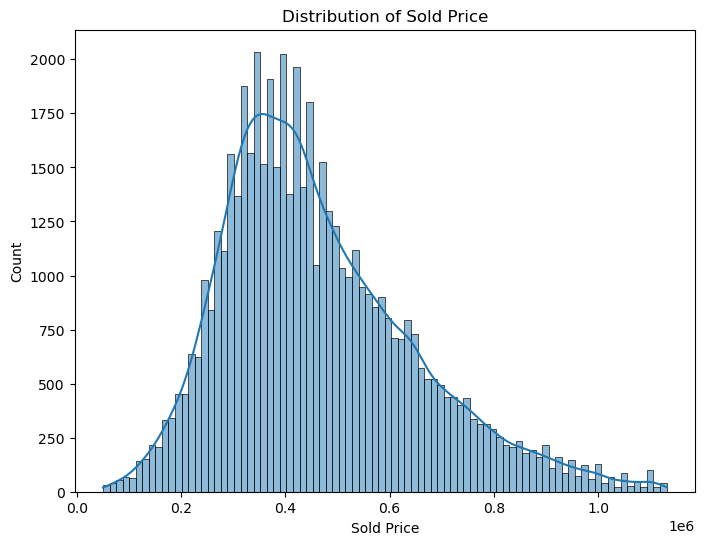

In [87]:
# Target variable analysis
plt.figure(figsize=(8, 6))
sns.histplot(sfr_df_encoded['Sold Price'], kde=True)
plt.title('Distribution of Sold Price')
plt.show()

In [88]:
# Round sold price to the nearest $500 increment
sfr_df_encoded['Sold Price'] = sfr_df_encoded['Sold Price'].apply(lambda x: round(x/500)*500)

In [89]:
print(sfr_df_encoded.columns)

Index(['MLS #', 'City', 'Zip', 'Bedrooms', 'Total Baths', 'SqFt', 'Acres',
       'Year Built', 'List Date', 'Closing Date', 'List Price', 'Sold Price',
       'Days on Market', 'Over Asking', 'List Year', 'List Month',
       'Closing Year', 'Closing Month', 'Price Increase Percentage',
       'Age of Property', 'Rate', 'Lat', 'Lon', 'spatial_feature_1',
       'spatial_feature_2', 'spatial_feature_3', 'spatial_feature_4',
       'spatial_feature_5', 'spatial_feature_6', 'spatial_feature_7',
       'spatial_feature_8', 'spatial_feature_9', 'spatial_feature_10',
       'spatial_feature_11', 'spatial_feature_12', 'spatial_feature_13',
       'spatial_feature_14', 'spatial_feature_15', 'spatial_feature_16',
       'spatial_feature_17', 'spatial_feature_18', 'spatial_feature_19',
       'spatial_feature_20', 'spatial_feature_21', 'spatial_feature_22',
       'spatial_feature_23', 'spatial_feature_24', 'spatial_feature_25',
       'spatial_feature_26', 'spatial_feature_27', 'spatial_featur

In [90]:
# Save the DataFrame to a CSV file
sfr_df_encoded.to_csv('Clean_Data/mls_sfr_cleaned.csv', index=False)

In [72]:
#Drop columns that won't be used
sfr_df_encoded.drop('MLS #', axis=1, inplace=True)
sfr_df_encoded.drop('City', axis=1, inplace=True)
sfr_df_encoded.drop('Zip', axis=1, inplace=True)
sfr_df_encoded.drop('Year Built', axis=1, inplace=True)
sfr_df_encoded.drop('List Date', axis=1, inplace=True)
sfr_df_encoded.drop('Closing Date', axis=1, inplace=True)
sfr_df_encoded.drop('List Price', axis=1, inplace=True)
sfr_df_encoded.drop('Days on Market', axis=1, inplace=True)
sfr_df_encoded.drop('Over Asking', axis=1, inplace=True)
sfr_df_encoded.drop('Closing Year', axis=1, inplace=True)
sfr_df_encoded.drop('Closing Month', axis=1, inplace=True)
#sfr_df_encoded.drop('Lat', axis=1, inplace=True)
#fr_df_encoded.drop('Lon', axis=1, inplace=True)
sfr_df_encoded.drop('Price Increase Percentage', axis=1, inplace=True)

In [73]:
print(sfr_df_encoded.columns)

Index(['Bedrooms', 'Total Baths', 'SqFt', 'Acres', 'Sold Price', 'List Year',
       'List Month', 'Age of Property', 'Rate', 'Lat', 'Lon',
       'spatial_feature_1', 'spatial_feature_2', 'spatial_feature_3',
       'spatial_feature_4', 'spatial_feature_5', 'spatial_feature_6',
       'spatial_feature_7', 'spatial_feature_8', 'spatial_feature_9',
       'spatial_feature_10', 'spatial_feature_11', 'spatial_feature_12',
       'spatial_feature_13', 'spatial_feature_14', 'spatial_feature_15',
       'spatial_feature_16', 'spatial_feature_17', 'spatial_feature_18',
       'spatial_feature_19', 'spatial_feature_20', 'spatial_feature_21',
       'spatial_feature_22', 'spatial_feature_23', 'spatial_feature_24',
       'spatial_feature_25', 'spatial_feature_26', 'spatial_feature_27',
       'spatial_feature_28', 'spatial_feature_29', 'spatial_feature_30',
       'spatial_feature_31', 'spatial_feature_32', 'City_Angier', 'City_Apex',
       'City_Benson', 'City_Burlington', 'City_Cary', 'City_

In [74]:
#Create a correlation matrix to see what the correlation is for Price per SqFt
corr_matrix = sfr_df_encoded.corr()
corr_matrix["Sold Price"].sort_values(ascending=False)

Sold Price            1.000000
SqFt                  0.750650
Total Baths           0.622471
Bedrooms              0.484341
City_Cary             0.220977
                        ...   
City_Rocky Mount     -0.133444
City_Clayton         -0.133974
City_Burlington      -0.163441
Age of Property      -0.273170
spatial_feature_15         NaN
Name: Sold Price, Length: 71, dtype: float64

In [76]:
# Save the DataFrame to a CSV file
sfr_df_encoded.to_csv('Clean_Data/sfr_cleaned_only_important_columns.csv', index=False)